# Dataset and instructions

Dataset https://archive.ics.uci.edu/dataset/62/lung+cancer

```
# Explorasi berbagai metode untuk mengatasi missing data
- Dropping samples
- Deletion features
- Missing data imputation (minimal 3 metode, lebih banyak lebih baik)

# Uji metode tersebut dengan sedikitnya 5 Klasifikasi
- Optimasi Hyperparameter dari setiap klasifikasi (menggunakan gridsearch dengan memvariasikan sedikitnya 1 hyperparameter)

# Evaluasi dan investigasi permutasi masing2 metode tersebut. Mana yang lebih baik? Analisa mengapa demikian

# Menurut kamu, apa yang bisa dilakukan untuk mengatasi missing data selain yang telah dilakukan diatas?
```

# Setup Dependencies

In [ ]:
# Setup dependencies
!pip install ucimlrepo
!pip install missingno
!pip install lightgbm
!pip install miceforest

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.4 MB/s eta 0:00:00


# Import Classess Needded

In [ ]:
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
import seaborn as sns
import pandas as pd
import miceforest as mf

In [ ]:
from ucimlrepo import fetch_ucirepo

from sklearn.experimental import enable_iterative_imputer # We need this for using IterativeImputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import \
  classification_report, accuracy_score, precision_score, recall_score, f1_score
  # \ mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor

# Understanding the data

In [ ]:
lung_cancer = fetch_ucirepo(id=62)

X = lung_cancer.data.features
# print(X.head(5))
print(X)

    Attribute1  Attribute2  Attribute3  Attribute4  Attribute5  Attribute6  \
0            0           3           0         NaN           0           2   
1            0           3           3         1.0           0           3   
2            0           3           3         2.0           0           3   
3            0           2           3         2.0           1           3   
4            0           3           2         1.0           1           3   
5            0           3           3         2.0           0           3   
6            0           3           2         1.0           0           3   
7            0           2           2         1.0           0           3   
8            0           3           1         1.0           0           3   
9            0           2           3         2.0           0           2   
10           0           2           2         0.0           0           3   
11           0           2           3         2.0           0  

<Axes: >

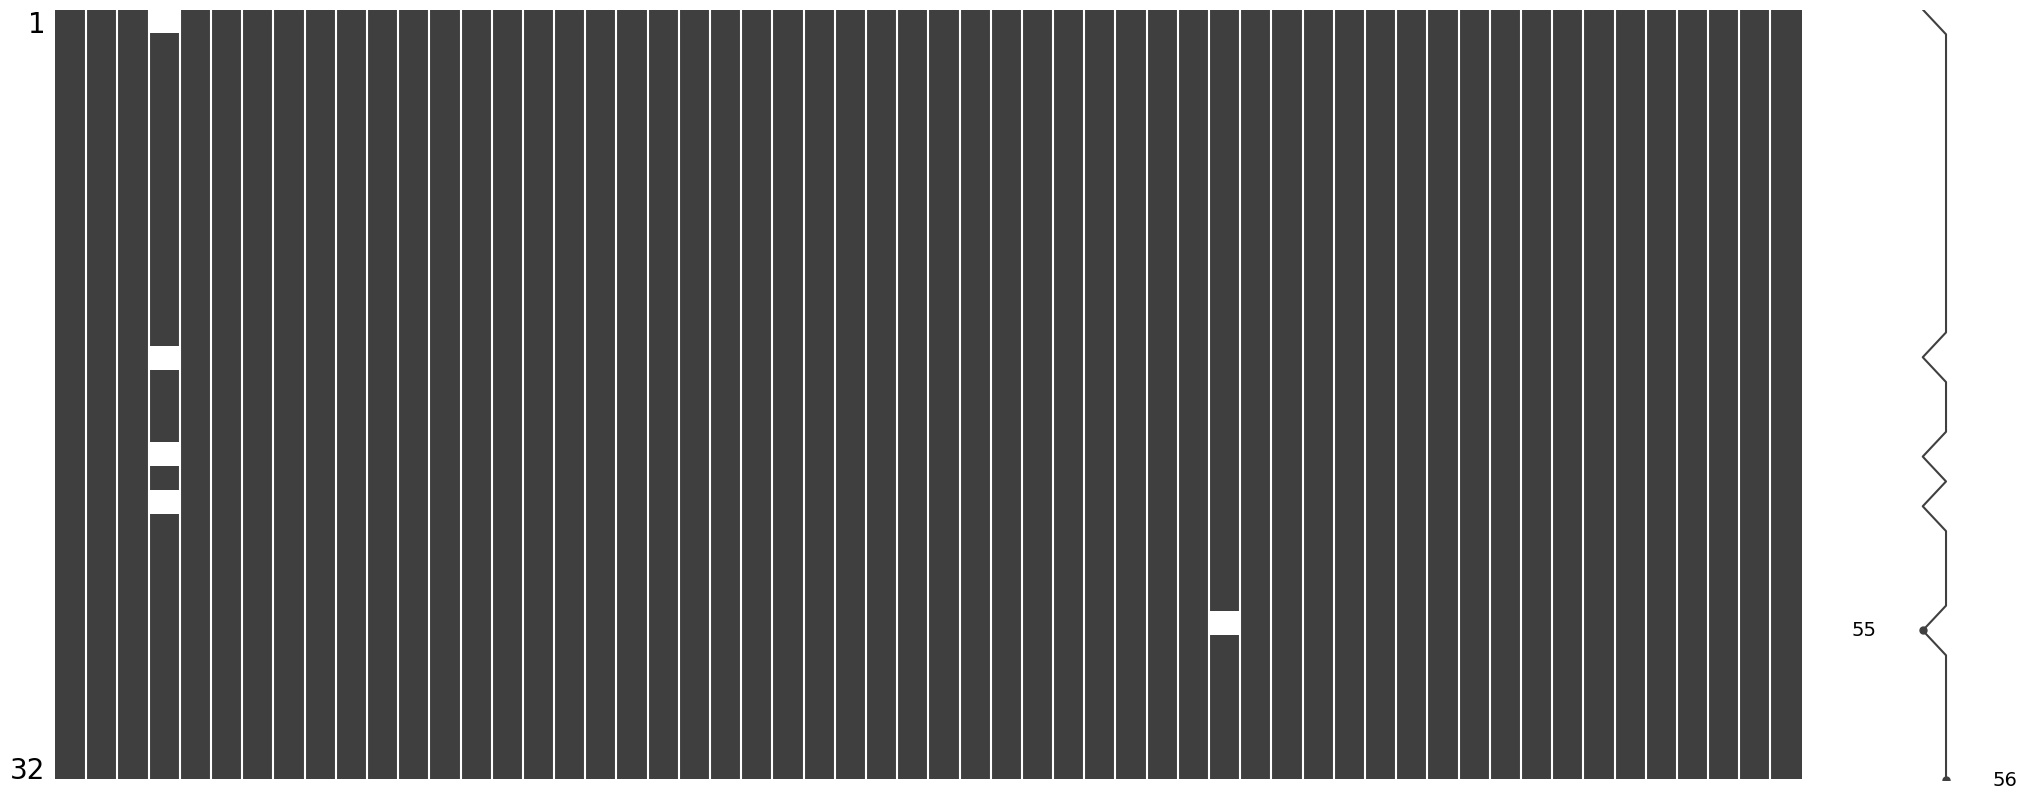

In [ ]:
msno.matrix(X)

In [ ]:
y = lung_cancer.data.targets
print(y.head(5))

print("Class values")
print(y["class"].unique())

X.describe()

   class
0      1
1      1
2      1
3      1
4      1
Class values
[1 2 3]


,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute47,Attribute48,Attribute49,Attribute50,Attribute51,Attribute52,Attribute53,Attribute54,Attribute55,Attribute56
count,32.000000,32.000000,32.000000,28.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,...,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,0.031250,2.375000,2.031250,1.392857,0.281250,2.187500,2.125000,2.406250,1.156250,1.406250,...,2.062500,2.062500,2.000000,2.000000,2.000000,1.843750,1.843750,1.562500,1.812500,1.718750
std,0.176777,0.553581,1.031265,0.566947,0.456803,0.737804,0.751343,0.756024,0.514899,0.559918,...,0.245935,0.245935,0.359211,0.359211,0.508001,0.447889,0.447889,0.504016,0.396558,0.456803
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,2.000000,1.750000,1.000000,0.000000,2.000000,2.000000,2.000000,1.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000
50%,0.000000,2.000000,2.000000,1.000000,0.000000,2.000000,2.000000,3.000000,1.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,0.000000,3.000000,3.000000,2.000000,1.000000,3.000000,3.000000,3.000000,1.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,1.000000,3.000000,3.000000,2.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000


In [ ]:
X[['Attribute4', 'Attribute38']].describe()

,Attribute4,Attribute38
count,28.000000,31.000000
mean,1.392857,1.709677
std,0.566947,0.588419
min,0.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,2.000000
75%,2.000000,2.000000
max,2.000000,3.000000


In [ ]:
X.corr()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute47,Attribute48,Attribute49,Attribute50,Attribute51,Attribute52,Attribute53,Attribute54,Attribute55,Attribute56
Attribute1,1.000000e+00,2.060214e-01,-3.594233e-01,NaN,2.871189e-01,-0.293701,-3.035884e-02,-0.098055,-5.537469e-02,-1.323983e-01,...,-4.637389e-02,-4.637389e-02,3.176256e-18,1.338649e-17,-1.047452e-17,0.063659,0.063659,-2.036533e-01,8.627960e-02,-2.871189e-01
Attribute2,2.060214e-01,1.000000e+00,-2.118938e-02,0.242197,-4.783649e-02,0.138215,-1.163350e-01,0.086711,-9.902466e-02,-2.992064e-01,...,-1.777047e-01,-1.777047e-01,-1.622214e-01,1.622214e-01,-1.147079e-01,0.243943,0.243943,-8.671100e-02,-2.571514e-01,3.029644e-01
Attribute3,-3.594233e-01,-2.118938e-02,1.000000e+00,0.403467,-1.925888e-02,0.076843,3.642821e-02,-0.099557,-2.524920e-01,-2.269535e-02,...,1.192393e-01,1.192393e-01,-8.708007e-02,-8.708007e-02,2.462996e-01,0.150590,0.150590,3.995220e-01,-1.429682e-01,-4.921715e-02
Attribute4,NaN,2.421971e-01,4.034673e-01,1.000000,3.703704e-02,-0.297082,-6.697737e-02,-0.026717,-1.849589e-01,7.818930e-02,...,-1.957122e-01,-1.957122e-01,-1.697250e-01,-1.697250e-01,7.809594e-02,-0.062439,-0.062439,4.222003e-02,-3.409752e-01,1.622882e-01
Attribute5,2.871189e-01,-4.783649e-02,-1.925888e-02,0.037037,1.000000e+00,-0.065802,2.702145e-01,-0.061297,-5.571605e-02,-8.276637e-02,...,1.256224e-01,1.256224e-01,1.965893e-01,1.965893e-01,-2.780192e-01,0.221718,0.221718,-1.488653e-01,3.005013e-01,-7.246377e-02
Attribute6,-2.937013e-01,1.382147e-01,7.684310e-02,-0.297082,-6.580223e-02,1.000000,3.055050e-01,0.495179,1.751335e-01,2.000952e-01,...,-6.666667e-02,-6.666667e-02,-1.217161e-01,1.217161e-01,-1.721326e-01,0.189133,0.091516,5.421667e-02,-9.647146e-02,2.572269e-01
Attribute7,-3.035884e-02,-1.163350e-01,3.642821e-02,-0.066977,2.702145e-01,0.305505,1.000000e+00,0.078085,3.126867e-02,2.587912e-01,...,-4.364358e-02,-4.364358e-02,2.390457e-01,-7.597496e-17,-8.451543e-02,-0.035947,-0.035947,4.046218e-01,-2.435994e-01,1.174846e-02
Attribute8,-9.805528e-02,8.671100e-02,-9.955727e-02,-0.026717,-6.129748e-02,0.495179,7.808491e-02,1.000000,2.460108e-01,2.071799e-01,...,-3.144567e-01,-3.144567e-01,-4.751311e-01,-1.187828e-01,-1.679842e-01,-0.092288,-0.092288,-2.804233e-01,-2.757148e-01,7.151372e-01
Attribute9,-5.537469e-02,-9.902466e-02,-2.524920e-01,-0.184959,-5.571605e-02,0.175133,3.126867e-02,0.246011,1.000000e+00,5.559543e-01,...,-7.960613e-02,-7.960613e-02,-3.488166e-01,-1.500792e-16,-8.900722e-17,0.109279,0.109279,-1.009939e-01,-1.678567e-01,1.928632e-01
Attribute10,-1.323983e-01,-2.992064e-01,-2.269535e-02,0.078189,-8.276637e-02,0.200095,2.587912e-01,0.207180,5.559543e-01,1.000000e+00,...,-1.903345e-01,-1.903345e-01,-3.207708e-01,-3.207708e-01,5.012121e-18,-0.124611,-0.124611,-3.572066e-02,-2.270009e-01,2.088866e-01


# Reusable functions

## Null, NaN value getter

In [ ]:
# print(lung_cancer)
# print(lung_cancer.metadata)
# print(lung_cancer.variables)

def get_null_values(data):
  null_values = data.isnull().sum()
  return null_values[null_values > 0]

print("Null values: \n")
print(get_null_values(X))

def get_nan_values(data):
  nan_values = data.isna().sum()
  return nan_values[nan_values > 0]

print("NaN values: \n")
print(get_nan_values(X))

# print(X.shape)

Null values: 

Attribute4     4
Attribute38    1
dtype: int64
NaN values: 

Attribute4     4
Attribute38    1
dtype: int64


## Getter default classifiers and hyperparameter

In [ ]:
# def get_default_classifier():
  # Without hyperparameter setting
  # classifiers = {
  #     'Support_vector_classification': {
  #         'class': SVC(),
  #         'params': {

  #         }
  #     },
  #     'random_forest_classifier': {
  #         'class': RandomForestClassifier(),
  #         'params': {

  #         }
  #     },
  #     'logistic_regression': {
  #         'class': LogisticRegression(
  #             solver='liblinear',
  #         ),
  #         'params': {
  #         }
  #     },
  #     'gaussian_naive_bayes': {
  #         'class': GaussianNB(),
  #         'params': {}
  #     },
  #     'gradient_boosting': {
  #         'class': GradientBoostingClassifier(),
  #         'params': {}
  #     }
  # }

  # with hyperparameter
  # classifiers = {
      # 'Support_vector_classification': {
      #     'class': SVC(),
      #     'params': {
      #         'C': [0.1, 1, 10],
      #         'kernel': ['linear', 'rbf', 'poly'],
      #         'gamma': ['scale', 'auto']
      #     }
      # },
      # 'random_forest_classifier': {
      #     'class': RandomForestClassifier(),
      #     'params': {
      #         'n_estimators': [10, 50, 100],
      #         'max_depth': [None, 10, 20],
      #         'min_samples_split': [2, 5, 10],
      #         'min_samples_leaf': [1, 2, 4]
      #     }
      # },
      # 'logistic_regression': {
      #     'class': LogisticRegression(
      #         solver='liblinear',
      #     ),
      #     'params': {
      #         'C': [0.1, 1, 10],
      #         'penalty': ['l1', 'l2']
      #     }
      # },
      # 'gaussian_naive_bayes': {
      #     'class': GaussianNB(),
      #     'params': {}
      # },
      # 'gradient_boosting': {
      #     'class': GradientBoostingClassifier(),
      #     'params': {
      #         'n_estimators': [50, 100, 200],
      #         'learning_rate': [0.01, 0.1, 0.2],
      #         'max_depth': [3, 5, 7]
      #     }
      # }
  # }

  # return classifiers

In [ ]:
def get_default_classifier():
  # Trying another classfiers
  # classifiers = {
  #     'dt': {
  #       'class': DecisionTreeClassifier(),
  #       'params': {}
  #     },
  #     'rf': {
  #         'class': RandomForestClassifier(),
  #         'params': {}
  #     },
  #     'svc': {
  #         'class': SVC(),
  #         'params': {}
  #     },
  #     'knn': {
  #       'class': KNeighborsClassifier(),
  #       'params': {}
  #     },
  #     'lr': {
  #         'class': LogisticRegression(
  #             solver='lbfgs',
  #             max_iter=1000
  #         ),
  #         'params': {}
  #     },
  #     'gaussian_nb': {
  #         'class': GaussianNB(),
  #         'params': {}
  #     }
  # }

  classifiers = {
      'dt': {
          'class': DecisionTreeClassifier(),
          'params': {
              'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': [None, 10, 20, 30],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]
          }
      },
      'rf': {
          'class': RandomForestClassifier(),
          'params': {
              'n_estimators': [50, 100, 200],
              'criterion': ['gini', 'entropy'],  # Criterion for splitting
              'max_depth': [None, 10, 20, 30],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'bootstrap': [True, False]
          }
      },
      'svc': {
          'class': SVC(),
          'params': {
              'C': [0.1, 1, 10],
              'kernel': ['linear', 'rbf', 'poly'],
              'degree': [3, 5],
              'gamma': ['scale', 'auto']
          }
      },
      'knn': {
          'class': KNeighborsClassifier(),
          'params': {
              'n_neighbors': [3, 5, 7, 9],
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
          }
      },
      'lr': {
          'class': LogisticRegression(),
          'params': {
            'penalty': ['l2'],  # Norm used in penalization
            'C': [0.1, 1, 10],  # Regularization parameter
            'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],  # Algorithm to use in the optimization problem
            'max_iter': [1000]  # Maximum number of iterations taken for the solvers to converge
          }
      },
      'gaussian_nb': {
          'class': GaussianNB(),
          'params': {
            'var_smoothing': [1e-9, 1e-8, 1e-7]  # Portion of the largest variance of all features to be added to variances for stability
          }
      }
  }

  return classifiers

## Display confusion matrix

In [ ]:
# Not yet tested
# def displayConfusionMatrix(test, prediction):
#   cm = confusion_matrix(test, prediction)

#   # Display the confusion matrix using seaborn
#   plt.figure(figsize=(8, 6))
#   sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
#               xticklabels=['Predicted 0', 'Predicted 1'],
#               yticklabels=['Actual 0', 'Actual 1'])
#   plt.xlabel('Predicted')
#   plt.ylabel('Actual')
#   plt.title('Confusion Matrix')
#   plt.show()


## Display in bar chart plot

In [ ]:
# Not yet tested
# def displayInPlot(model_name, data, train_accuracy, test_accuracy):
#   plt.plot(data, train_accuracy, label='Train Accuracy')
#   plt.plot(data, test_accuracy, label='Test Accuracy')
#   plt.legend(loc='best')
#   plt.title(model_name)
#   plt.xlabel('Neighbors')
#   plt.ylabel('Accuracy (%)')
#   plt.xticks(data)
#   plt.show()

def displayBarChartPlot(classifiers, accuracy_list, method):
  classifiers_names = list(classifiers.keys())

  fig, ax = plt.subplots()

  ax.bar(classifiers_names, accuracy_list, label='Accuracy', color='skyblue')

  ax.set_xlabel('Classifiers')
  ax.set_ylabel('Accuracy')
  ax.set_title(f'Accuracy Comparison of Classifiers: {method}')
  ax.legend()

  plt.show()

# Classifier Implementor

In [ ]:
def classifier_implementor(
  X, y,
  classifiers={}, test_size=0.2, random_state=0, cv=5,
  chart_title_method_name=''
):
  X_train, X_test, y_train, y_test = model_selection.train_test_split(
      X,
      y,
      test_size=test_size,
      random_state=random_state
  )

  list_acuracy_score = []
  for name, classifier in classifiers.items():
    # print(f" Name {name}, class: {classifier['class']}, params: {classifier['params']} ")
    gs_cv = GridSearchCV(
        classifier['class'],
        classifier['params'],
        cv=cv
      )
    print(f"=========================================={name} ==========================================")
    print("Model & Hyperparameters", classifier)
    gs_cv.fit(X_train, y_train)

    # print('========================= X_test \n', X_test)
    # print('========================= y_test \n', y_test)

    # print("==========================================Training process==========================================")
    # print(f"X Training: \n{X_train.head(3)}")
    # print(f"Y Training: \n{y_train.head(3)}")
    training_accuracy = gs_cv.score(X_train, y_train) * 100
    # print("====================================================================================================")

    # print("==========================================Testing process==========================================")
    predictions = gs_cv.predict(X_test)
    # print(f"Prediction: {predictions}")
    # print(f"Testing Data: \n{y_test}")
    testing_accuracy = accuracy_score(y_test, predictions) * 100
    list_acuracy_score.append(testing_accuracy)
    # print("====================================================================================================")

    print("==========================================Result==========================================")
    best_score = gs_cv.best_score_ * 100
    print(f"[Best params]: {gs_cv.best_params_}")
    print(f"[Best Score]: {float(format(best_score,'.2f'))}")


    print(f"[Training] Accuracy score: {float(format(training_accuracy,'.2f'))}")
    print(f"[Testing] Accuracy score: {float(format(testing_accuracy,'.2f'))}")

    print(f"[Training] Accuracy score: {float(format(training_accuracy,'.2f'))}")
    print(f"[Testing] Accuracy score: {float(format(testing_accuracy,'.2f'))}")


    # # Calculate precision
    # precision = precision_score(y_test, y_pred)
    # print("Precision:", precision)

    # # Calculate recall (sensitivity)
    # recall = recall_score(y_test, y_pred)
    # print("Recall (Sensitivity):", recall)

    # # Calculate F1-score
    # f1 = f1_score(y_test, y_pred)
    # print("F1-Score:", f1)

    print("==========================================================================================")
    print("==========================================Process finished ==========================================")

    print("\n")

  displayBarChartPlot(classifiers, list_acuracy_score, chart_title_method_name)
  return list_acuracy_score

    # DecisionTreeClassifier(),
    # KNeighborsClassifier(),

    # GradientBoostingClassifier(),
    # AdaBoostClassifier(),

  # xgboost classification?
  # Neural network classification


## Impementing origin data to classifiers

an expected error raised: NaN value

In [ ]:
# classifiers = {
#     'Support_vector_classification': { # SVC does not accept missing values encoded as NaN natively
#         'class': SVC(),
#         'params': {

#         }
#     },
#     'random_forest_classifier': { # RandomForestClassifier does not accept missing values encoded as NaN natively
#         'class': RandomForestClassifier(),
#         'params': {

#         }
#     },
#     'logistic_regression': { # LogisticRegression does not accept missing values encoded as NaN natively
#         'class': LogisticRegression(
#             # set solver to liblinear otherwise got tihs error -> ConvergenceWarning: lbfgs failed to converge (status=1): STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
#             solver='liblinear',
#             # max_iter=10,
#             # C=0.3
#         ),
#         'params': {
#           # 'solver': [''],
#           # 'C': [0.1, 0.3, 0.5, 0.7, 1.0, 2.0, 5.0],
#           # 'max_iter': [1,10,100,1000]
#         }
#     },
#     'gaussian_naive_bayes': {
#         'class': GaussianNB(),
#         'params': {}
#     },
#     'gradient_boosting': {
#         'class': GradientBoostingClassifier(),
#         'params': {}
#     }
# }

# classifier_implementor(X, y, classifiers, test_size=0.2, cv=5)

# =====================================================================
# Codes above will always be commented due to an expected error raised
# =====================================================================

# ```
# ---------------------------------------------------------------------------
# ValueError                                Traceback (most recent call last)
# <ipython-input-73-190b6e0359d1> in <cell line: 37>()
#      35 }
#      36
# ---> 37 classifier_implementor(X, y, classifiers, test_size=0.2, cv=5)

# 4 frames
# /usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py in _warn_or_raise_about_fit_failures(results, error_score)
#     365                 f"Below are more details about the failures:\n{fit_errors_summary}"
#     366             )
# --> 367             raise ValueError(all_fits_failed_message)
#     368
#     369         else:

# ValueError:
# All the 5 fits failed.
# It is very likely that your model is misconfigured.
# You can try to debug the error by setting error_score='raise'.

# Below are more details about the failures:
# --------------------------------------------------------------------------------
# 5 fits failed with the following error:
# Traceback (most recent call last):
#   File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
#     estimator.fit(X_train, y_train, **fit_params)
#   File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 192, in fit
#     X, y = self._validate_data(
#   File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 584, in _validate_data
#     X, y = check_X_y(X, y, **check_params)
#   File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1106, in check_X_y
#     X = check_array(
#   File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 921, in check_array
#     _assert_all_finite(
#   File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 161, in _assert_all_finite
#     raise ValueError(msg_err)
# ValueError: Input X contains NaN.
# SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
# ```

## Dropping samples

A good benchmark would be at least 80% of your original data, subject to overall dataset size. E.g. if you have 1 000 000 rows in your original dataset with NaNs, then dropping 400K rows should not cause problems.

Pros
- A model trained with the removal of all missing values creates a robust model.

Cons
- Loss of a lot of information.
- Works poorly if the percentage of missing values is excessive in comparison to the complete dataset.

Null values before dropping NULL Samples: 
Attribute4     4
Attribute38    1
dtype: int64 

Null values after dropping NULL Samples: 
Series([], dtype: int64) 

==========================================dt ==========================================
Model & Hyperparameters {'class': DecisionTreeClassifier(), 'params': {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}}
==========================================Result==========================================
[Best params]: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
[Best Score]: 76.0
[Training] Accuracy score: 100.0
[Testing] Accuracy score: 33.33
[Training] Accuracy score: 100.0
[Testing] Accuracy score: 33.33
==========================================Process finished ==========================================


==========================================rf ==

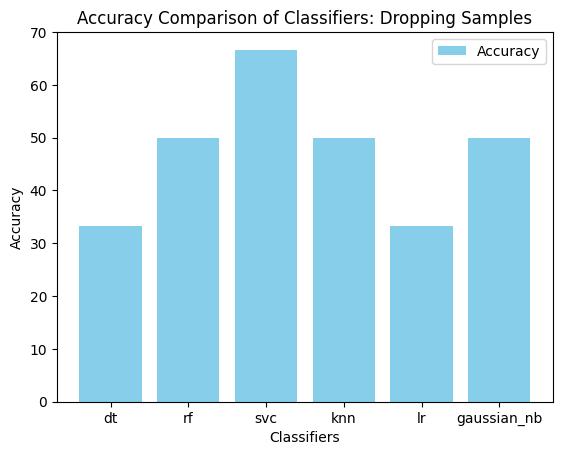

In [ ]:
print(f"Null values before dropping NULL Samples: \n{get_null_values(X)} \n")

data = X.copy()
data.dropna(inplace=True)
print(f"Null values after dropping NULL Samples: \n{get_null_values(data)} \n")

targets = y.loc[data.index, 'class']
# print(targets)

# msno.matrix(data)

# Implementing to the classifiers
classifiers = get_default_classifier()
accuracy_list = classifier_implementor(
  data, targets, classifiers,
  chart_title_method_name='Dropping Samples'
)

## Deleting Features

Dropping whole columns with NaNs is yet another option. This could be valid if a column consists of over 50–70 percent of missing values, otherwise you may be removing valuable information from your data.

Null values before dropping Features: 
Attribute4     4
Attribute38    1
dtype: int64 

Null values after dropping Features: 
Series([], dtype: int64) 

==========================================dt ==========================================
Model & Hyperparameters {'class': DecisionTreeClassifier(), 'params': {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}}
==========================================Result==========================================
[Best params]: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'}
[Best Score]: 64.0
[Training] Accuracy score: 88.0
[Testing] Accuracy score: 71.43
[Training] Accuracy score: 88.0
[Testing] Accuracy score: 71.43
==========================================Process finished ==========================================


==========================================rf ===========

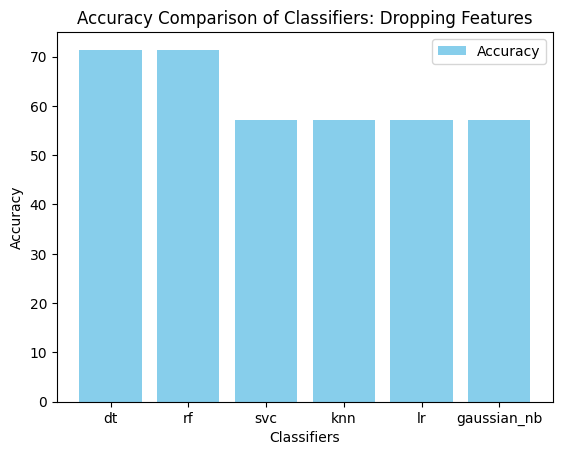

In [ ]:
print(f"Null values before dropping Features: \n{get_null_values(X)} \n")
data = X.copy()
data.dropna(axis=1, inplace=True)
print(f"Null values after dropping Features: \n{get_null_values(data)} \n")

targets = y.loc[data.index, 'class']
# print(targets)

# msno.matrix(data)

# Implementing to classifiers
classifiers = get_default_classifier()
accuracy_list = classifier_implementor(
  data, targets, classifiers,
  chart_title_method_name='Dropping Features'
)

## Data Imputation (Mode)

Null values before data imputation (Mode): 
Attribute4     4
Attribute38    1
dtype: int64 

Null values after data imputation (Mode): 
Series([], dtype: int64) 

==========================================dt ==========================================
Model & Hyperparameters {'class': DecisionTreeClassifier(), 'params': {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}}
==========================================Result==========================================
[Best params]: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'random'}
[Best Score]: 60.0
[Training] Accuracy score: 80.0
[Testing] Accuracy score: 57.14
[Training] Accuracy score: 80.0
[Testing] Accuracy score: 57.14
==========================================Process finished ==========================================


==========================================rf 

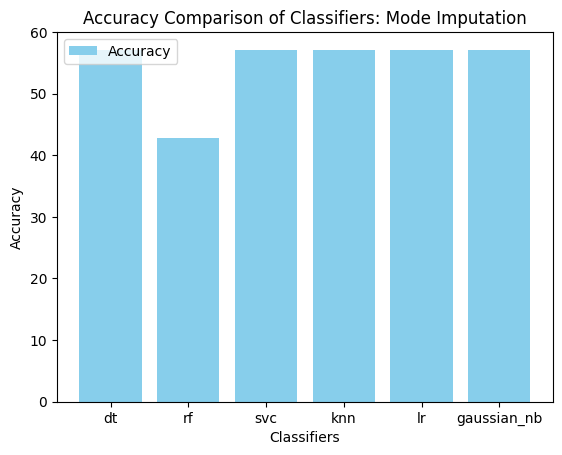

In [ ]:
data = X.copy()
print(f"Null values before data imputation (Mode): \n{get_null_values(data)} \n")

most_frequent_attribute4 = data["Attribute4"].mode()[0]
data["Attribute4"] = data["Attribute4"].fillna(most_frequent_attribute4)

most_frequent_attribute38 = data["Attribute38"].mode()[0]
data["Attribute38"] = data["Attribute38"].fillna(most_frequent_attribute38)

print(f"Null values after data imputation (Mode): \n{get_null_values(data)} \n")

# Implementing to classifiers
classifiers = get_default_classifier()
targets = y.loc[data.index, 'class']
accuracy_list = classifier_implementor(
  data, targets, classifiers,
  chart_title_method_name='Mode Imputation'
)

## Data Imputation (Median)

Pros:

- Easy and fast.
- Works well with small numerical datasets.

Cons:

- Doesn't factor the correlations between features. It only works on the column level.
- Will give poor results on encoded categorical features (do NOT use it on categorical features).
- Not very accurate.
- Doesn't account for the uncertainty in the imputations.

Null values before data imputation (median): 
Attribute4     4
Attribute38    1
dtype: int64 

Null values after data imputation (median): 
Series([], dtype: int64) 

==========================================dt ==========================================
Model & Hyperparameters {'class': DecisionTreeClassifier(), 'params': {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}}
==========================================Result==========================================
[Best params]: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'}
[Best Score]: 60.0
[Training] Accuracy score: 96.0
[Testing] Accuracy score: 71.43
[Training] Accuracy score: 96.0
[Testing] Accuracy score: 71.43
==========================================Process finished ==========================================


==========================================

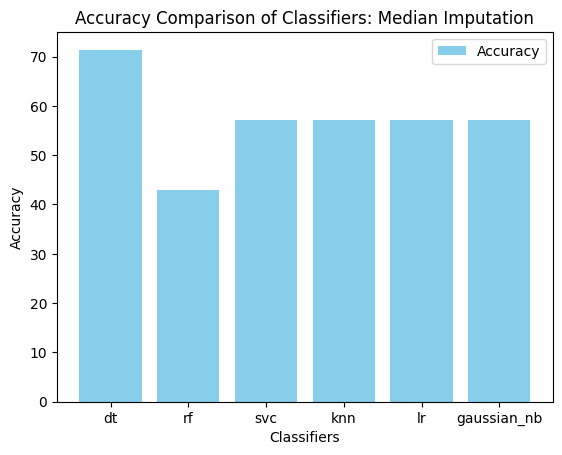

In [ ]:
data = X.copy()
print(f"Null values before data imputation (median): \n{get_null_values(data)} \n")

median_attribute_4 = data["Attribute4"].median()
# print(median_attribute_4)
data["Attribute4"] = data["Attribute4"].fillna(median_attribute_4)

median_attribute_38 = data["Attribute38"].median()
# print(median_attribute_38)
data["Attribute38"] = data["Attribute38"].fillna(median_attribute_38)

print(f"Null values after data imputation (median): \n{get_null_values(data)} \n")

# Implementing to classifiers
classifiers = get_default_classifier()
targets = y.loc[data.index, 'class']
accuracy_list = classifier_implementor(
  data, targets, classifiers,
  chart_title_method_name='Median Imputation'
)

## Data Imputation (Mean)

Pros:

- Easy and fast.
- Works well with small numerical datasets.

Cons:

- Doesn't factor the correlations between features. It only works on the column level.
- Will give poor results on encoded categorical features (do NOT use it on categorical features).
- Not very accurate.
- Doesn't account for the uncertainty in the imputations.


Null values before data imputation (mean): 
Attribute4     4
Attribute38    1
dtype: int64 

Null values after data imputation (mean): 
Series([], dtype: int64) 

==========================================dt ==========================================
Model & Hyperparameters {'class': DecisionTreeClassifier(), 'params': {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}}
==========================================Result==========================================
[Best params]: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'random'}
[Best Score]: 60.0
[Training] Accuracy score: 72.0
[Testing] Accuracy score: 42.86
[Training] Accuracy score: 72.0
[Testing] Accuracy score: 42.86
==========================================Process finished ==========================================


==========================================rf ===

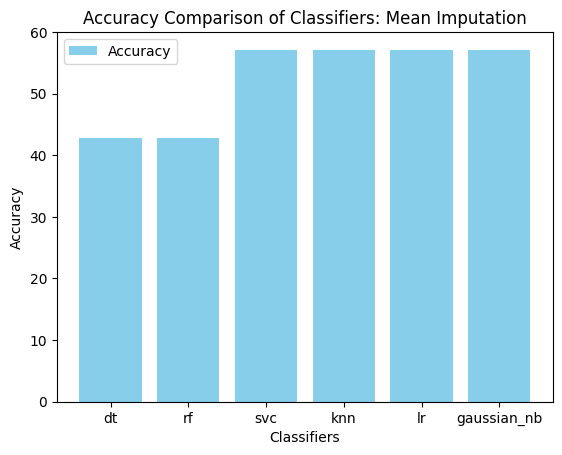

In [ ]:
data = X.copy()
print(f"Null values before data imputation (mean): \n{get_null_values(data)} \n")

mean_attribute_4 = data["Attribute4"].mean()
# print(mean_attribute_4)
data["Attribute4"] = data["Attribute4"].fillna(mean_attribute_4)

mean_attribute_38 = data["Attribute38"].mean()
# print(mean_attribute_38)
data["Attribute38"] = data["Attribute38"].fillna(mean_attribute_38)

print(f"Null values after data imputation (mean): \n{get_null_values(data)} \n")

# Implementing to classifiers
classifiers = get_default_classifier()
targets = y.loc[data.index, 'class']
accuracy_list = classifier_implementor(
  data, targets, classifiers,
  chart_title_method_name='Mean Imputation'
)

## Mean, Median, Mode using sklearn SimpleImputer

### Mean

==========================================dt ==========================================
Model & Hyperparameters {'class': DecisionTreeClassifier(), 'params': {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}}
==========================================Result==========================================
[Best params]: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}
[Best Score]: 60.0
[Training] Accuracy score: 84.0
[Testing] Accuracy score: 57.14
[Training] Accuracy score: 84.0
[Testing] Accuracy score: 57.14
==========================================Process finished ==========================================


==========================================rf ==========================================
Model & Hyperparameters {'class': RandomForestClassifier(), 'params': {'n_estimators': [50, 100, 200], 'criterion': ['gin

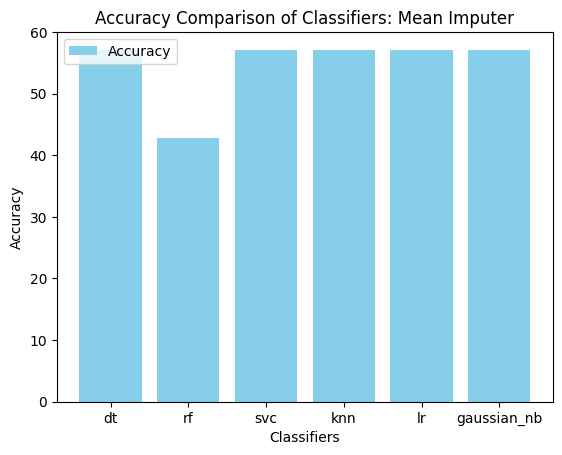

In [ ]:
data = X.copy()

imputer = SimpleImputer(strategy='mean')
data[['Attribute4', 'Attribute38']] = np.round(imputer.fit_transform(data[['Attribute4', 'Attribute38']]))
# print(data)

# Implementing to classifiers
classifiers = get_default_classifier()
targets = y.loc[data.index, 'class']
accuracy_list = classifier_implementor(
  data, targets, classifiers,
  chart_title_method_name='Mean Imputer'
)

### Median

In [ ]:
data = X.copy()

imputer = SimpleImputer(strategy='median')
data[['Attribute4', 'Attribute38']] = np.round(imputer.fit_transform(data[['Attribute4', 'Attribute38']]))
# print(data)

# Implementing to classifiers
classifiers = get_default_classifier()
targets = y.loc[data.index, 'class']
accuracy_list = classifier_implementor(
  data, targets, classifiers,
  chart_title_method_name='Median Imputer'
)

### Modus

In [ ]:
data = X.copy()

imputer = SimpleImputer(strategy='most_frequent')
data[['Attribute4', 'Attribute38']] = imputer.fit_transform(data[['Attribute4', 'Attribute38']])
# print(data)

# Implementing to classifiers
classifiers = get_default_classifier()
targets = y.loc[data.index, 'class']
accuracy_list = classifier_implementor(
  data, targets, classifiers,
  chart_title_method_name='Mode Imputer'
)

## Data imputation constant value

In [ ]:
data = X.copy()

# print(data[['Attribute4', 'Attribute38']])

constant_value = 3
imputer = SimpleImputer(strategy='constant', fill_value=constant_value)
data[['Attribute4', 'Attribute38']] = imputer.fit_transform(data[['Attribute4', 'Attribute38']])

# Implementing to classifiers
classifiers = get_default_classifier()
targets = y.loc[data.index, 'class']
accuracy_list = classifier_implementor(
  data, targets, classifiers,
  chart_title_method_name=f'Constant Value={constant_value}'
)

## Data Imputation (XGBoost)

A much better approach to dealing with missing values is predicting them with machine learning. This is a much more accurate solution to the problem.

### Fill missing values with predicted feature Attribute4

In [ ]:
data = X.copy()

feature_4 = "Attribute4"
idx_data_nan = data[data[feature_4].isnull()].index
print(idx_data_nan)

data_test = data[data.index.isin(idx_data_nan)]
print(f"Data testing: \n{data_test[feature_4]}")

data_train = data.drop(idx_data_nan, axis = 0)
# data_train[feature_4] = data_train[feature_4].astype(int) # convert continue to discret
print(f"\n Data training: \n{data_train[feature_4]}")

# select, initialize model
from xgboost import XGBRegressor # Move to import section
model = XGBRegressor()

# fit on your training set for a particular column
model.fit(data_train.drop(feature_4, axis = 1), data_train[feature_4])
# predict
pred_col = model.predict(data_test.drop(feature_4, axis = 1))

# place your predictions into the locations of the missing values in your full dataset
data.loc[idx_data_nan, feature_4] = pred_col
# data[feature_4] = data[feature_4].apply(np.round)
data[feature_4] = data[feature_4].apply(np.floor)

print(data[feature_4])

### Fill missing values with predicted feature Attribute38

In [ ]:
feature_38 = "Attribute38"
idx_data_nan = data[data[feature_38].isnull()].index
print(idx_data_nan)

data_test = data[data.index.isin(idx_data_nan)]
print(f"Data testing: \n{data_test[feature_38]}")

data_train = data.drop(idx_data_nan, axis = 0)
# data_train[feature_38] = data_train[feature_38].astype(int) # convert continue to discret
print(f"\n Data training: \n{data_train[feature_38]}")

# select, initialize model
model = XGBRegressor()

# fit on your training set for a particular column
model.fit(data_train.drop(feature_38, axis = 1), data_train[feature_38])
# predict
pred_col = model.predict(data_test.drop(feature_38, axis = 1))

# place your predictions into the locations of the missing values in your full dataset
data.loc[idx_data_nan, feature_38] = pred_col
# data[feature_38] = data[feature_38].apply(np.round)
data[feature_38] = data[feature_38].apply(np.floor)

# print(data[feature_38])

In [ ]:
# Implementing to classifiers
classifiers = get_default_classifier()
targets = y.loc[data.index, 'class']
classifier_implementor(data, targets, classifiers, test_size=0.2, cv=5)

### Using verstack

In [ ]:
# not yet tested...
# pip install verstack

# from verstack import NaNImputer
# imputer = NaNImputer()
# df_withot_nans = imputer.impute(df_with_nans)

## Data Imputation (LightGBM to predict missing value)

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
train_data = lgb.Dataset(X_train, label=y_train)

# Set the parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'learning_rate': 0.05,
    'num_leaves': 3,
    'max_depth':3,
    'min_child_samples': 3,
    # 'n_estimators': 10 # https://github.com/microsoft/LightGBM/issues/3676
}

# Train the LightGBM model
model = lgb.train(params, train_data)
# print(model)

# Predict missing values
# y_pred = model.predict(X_test)
# print(y_pred)

# fill missing value
data = X.copy()
missing_attribute4 = data["Attribute4"].isnull()
data.loc[missing_attribute4, 'Attribute4'] = np.floor(model.predict(data.loc[missing_attribute4, data.columns]))

missing_attribute38 = data["Attribute38"].isnull()
data.loc[missing_attribute38, 'Attribute38'] = np.floor(model.predict(data.loc[missing_attribute38, data.columns]))

# print(data["Attribute4"])
# print(data["Attribute38"])

# Implementing to classifiers
classifiers = get_default_classifier()
targets = y.loc[data.index, 'class']
accuracy_list = classifier_implementor(
  data, targets, classifiers,
  chart_title_method_name='LightGBM Imputer'
)

## LightGBM missing value handled automaticaly

In [ ]:
# This works well, but remarked due to does not contribute to the research (for now)
# X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
# train_data = lgb.Dataset(X_train, label=y_train)

# # Set the parameters for LightGBM
# params = { # TO DO: Tweak this params to make better model's result?
#     'objective': 'regression',
#     'metric': 'mse',
#     'boosting_type': 'gbdt',
#     'colsample_bytree': 0.8,
#     'subsample': 0.8,
#     'learning_rate': 0.05,
#     'num_leaves': 3,
#     'max_depth':3,
#     'min_child_samples': 3,
#     # 'n_estimators': 10 # https://github.com/microsoft/LightGBM/issues/3676
# }

# # Train the LightGBM model
# model = lgb.train(params, train_data)
# # print(model)

# # Predict missing values
# y_pred = model.predict(X_test)
# print(y_pred)

# # Evaluate the model
# mse = mean_squared_error(y_test, y_pred) * 100
# mae = mean_absolute_error(y_test, y_pred) * 100
# r2 = r2_score(y_test, y_pred) * 100

# print(f'Mean Squared Error (MSE): {mse}') # this is not the right measurement for classification
# print(f'Mean Absolute Error (MAE): {mae}') # this is not the right measurement for classification
# print(f'R-squared (R2): {r2}') # this is not the right measurement for classification

## Multivariate Imputation by Chained Equation (MICE)

MICE (MULTIPLE IMPUTATION BY CHAINED EQUATIONS) = Multiple imputation is a series of stochastic regression imputation

### ATAU

FILLING IN HOLES WITH STATISTICS
Recognizing the inherent uncertainty in missing data, we adopt and advocate the method of multiple imputation using Bayesian methods (“chained equations”)

In [ ]:
# # Create a sample point cloud.
# X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
#                            n_redundant=0, n_repeated=0, n_classes=3,
#                            n_clusters_per_class=1,
#                            weights=[0.05, 0.10, 0.85],
#                            class_sep=2, random_state=0)

# # Select indices to drop labels from.
# X_l = X.shape[0]
# np.random.seed(42)
# unl_idx = np.random.randint(0, len(X), size=X_l - 500)

# # Back the labels up and drop them.
# y = y.astype('float64')
# X_train, y_train = X[unl_idx].copy(), y[unl_idx].copy()
# X[unl_idx] = np.nan
# y[unl_idx] = np.nan

# # The fancyimpute package takes a single combined matrix as input. It differs in this from the X feature matrix, y response vector style of sklearn.
# f = np.hstack((X, y[:, None]))

# # Impute the missing values.
# from fancyimpute import MICE
# trans = MICE(verbose=False)
# f_complete = trans.complete(f)

## KNN Imputer

In [ ]:
# fill missing value using KNN
data = X.copy()

imputer = KNNImputer(n_neighbors=2, weights="uniform")
imputed_data = pd.DataFrame(imputer.fit_transform(data), columns = data.columns)

# Implementing to classifiers
classifiers = get_default_classifier()
targets = y.loc[data.index, 'class']
accuracy_list = classifier_implementor(
  imputed_data, targets, classifiers,
  chart_title_method_name='KNN Imputer'
)

## Linear Regression Imputer

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


==========================================dt ==========================================
Model & Hyperparameters {'class': DecisionTreeClassifier(), 'params': {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}}
==========================================Result==========================================
[Best params]: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}
[Best Score]: 64.0
[Training] Accuracy score: 80.0
[Testing] Accuracy score: 57.14
[Training] Accuracy score: 80.0
[Testing] Accuracy score: 57.14
==========================================Process finished ==========================================


==========================================rf ==========================================
Model & Hyperparameters {'class': RandomForestClassifier(), 'params': {'n_estimators': [50, 100, 200], 'criterion': ['gi

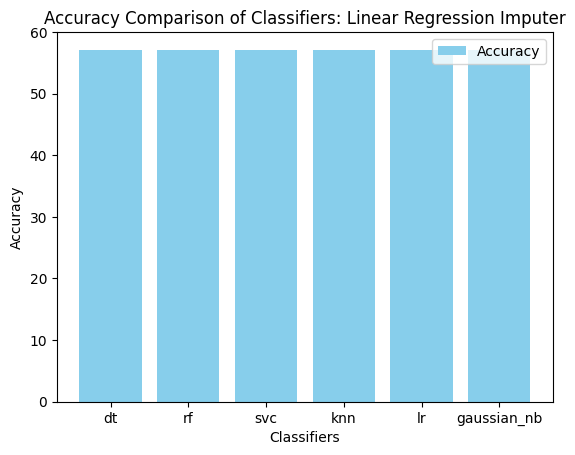

In [ ]:
data = X.copy()
lr = LinearRegression()

imputer = IterativeImputer(
    estimator=lr,
    random_state=100,
    # verbose=2,
    max_iter=10, # ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
    tol=1e-10,
    imputation_order='roman'
)
imputed_data = pd.DataFrame(imputer.fit_transform(data), columns = data.columns)
# print(imputed_data)

# Implementing to classifiers
classifiers = get_default_classifier()
targets = y.loc[data.index, 'class']
accuracy_list = classifier_implementor(
  imputed_data, targets, classifiers,
  chart_title_method_name='Linear Regression Imputer'
)

## Miceforest

==========================================dt ==========================================
Model & Hyperparameters {'class': DecisionTreeClassifier(), 'params': {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}}
==========================================Result==========================================
[Best params]: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'random'}
[Best Score]: 60.0
[Training] Accuracy score: 80.0
[Testing] Accuracy score: 57.14
[Training] Accuracy score: 80.0
[Testing] Accuracy score: 57.14
==========================================Process finished ==========================================


==========================================rf ==========================================
Model & Hyperparameters {'class': RandomForestClassifier(), 'params': {'n_estimators': [50, 100, 200], 'criterion': ['gini'

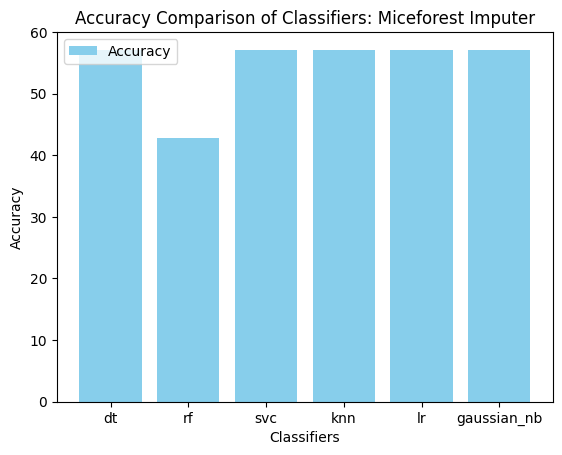

In [ ]:
kds = mf.ImputationKernel(
  X,
  save_all_iterations=True,
  random_state=100
)

# Run the MICE algorithm for 2 iterations
kds.mice(2)

# Return the completed dataset.
df_imputed = kds.complete_data()
# df_imputed.head()

# Implementing to classifiers
classifiers = get_default_classifier()
targets = y.loc[data.index, 'class']
accuracy_list = classifier_implementor(
  imputed_data, targets, classifiers,
  chart_title_method_name='Miceforest Imputer'
)

## Stochastic regression imputation -- belum

## Interpolation

In [ ]:
data = X.copy()

data.interpolate(limit_direction="both", inplace=True)

# Implementing to classifiers
classifiers = get_default_classifier()
targets = y.loc[data.index, 'class']
accuracy_list = classifier_implementor(
  imputed_data, targets, classifiers,
  chart_title_method_name='Interpolation Imputer'
)

## Hot-Deck imputation -- belum

## Maximum likelihood imputation --belum

Expectation Maximization: Replacing missing values by exploring the covariationamong variables in order to infer values for the missing data

Advantages: EM preserves the relationship with other variables, unlike mean imputation

Disadvantages: EM can sometime underestimate standard error

## Variational Autoencoder Imputation -- belum

Dataset
https://archive.ics.uci.edu/dataset/46/hepatitis

Dataset https://archive.ics.uci.edu/dataset/161/mammographic+mass